# Main solver

--- Global Stiffness Matrix (K_global) ---
[[ 1.600e+08  4.000e+07 -1.600e+08  4.000e+07  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 4.000e+07  1.333e+07 -4.000e+07  6.667e+06  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [-1.600e+08 -4.000e+07  3.200e+08  0.000e+00 -1.600e+08  4.000e+07  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 4.000e+07  6.667e+06  0.000e+00  2.667e+07 -4.000e+07  6.667e+06  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00 -1.600e+08 -4.000e+07  3.200e+08  0.000e+00 -1.600e+08  4.000e+07  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  4.000e+07  6.667e+06  0.000e+00  2.667e+07 -4.000e+07  6.667e+06  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  0

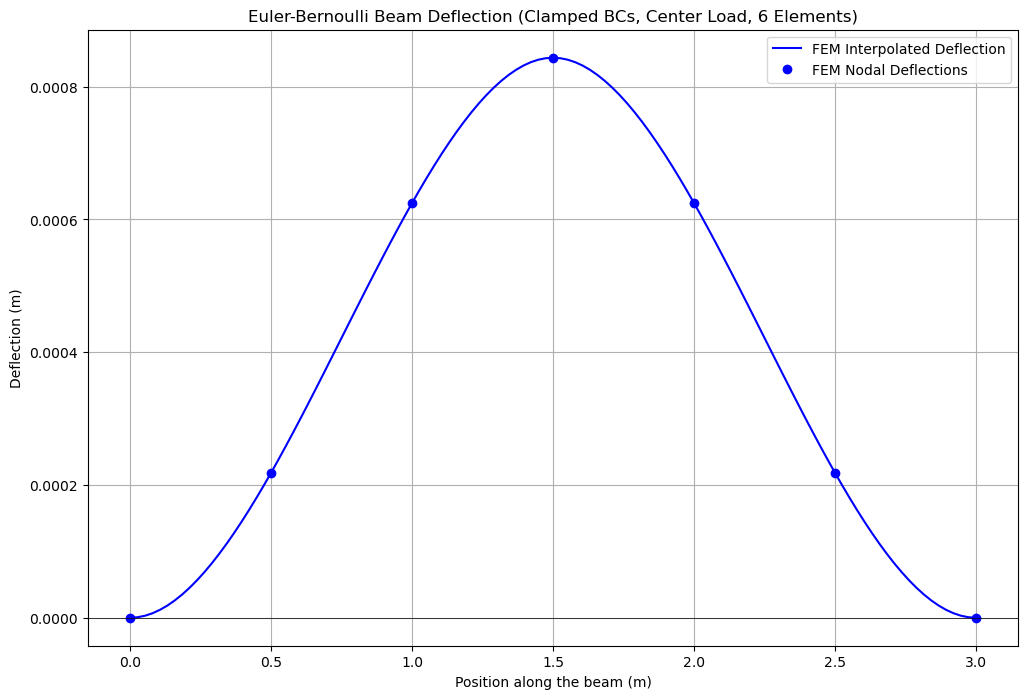

In [3]:
import numpy as np
from scipy.sparse import coo_array, csc_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

def lengths(p, t):
    """Calculate element lengths.
    
    Parameters
    ----------
    p : np.ndarray
        The nodes of the mesh (1D coordinates).
    t : np.ndarray
        The elements of the mesh (2 x M array, where M is number of elements).
        t[0,:] are start nodes, t[1,:] are end nodes of elements.
        
    Returns
    -------
    np.ndarray
        An array of element lengths, in the same order as elements are given in t.
    """
    start_indices = t[0, :]
    end_indices = t[1, :]
    coords_start = p[start_indices]
    coords_end = p[end_indices]
    elem_lengths = np.abs(coords_end - coords_start)
    return elem_lengths

def elemental_stiffness_beam(h_vals, EI):
    """Calculate elemental stiffness matrices for the Euler-Bernoulli beam.
    
    Parameters
    ----------
    h_vals : np.ndarray
        An array of M element lengths.
    EI : float
        Flexural rigidity (Young's modulus * moment of inertia).
        
    Returns
    -------
    np.ndarray
        A 4 x 4 x M array of elemental stiffness matrices.
    """
    M = len(h_vals)
    K_elems = np.zeros((4, 4, M))

    for j in range(M):
        h = h_vals[j]
        h2 = h * h
        h3 = h * h * h
        
        # Stiffness matrix for a beam element
        k_j = (EI / h3) * np.array([
            [12,    6*h,   -12,    6*h],
            [6*h,   4*h2,  -6*h,   2*h2],
            [-12,  -6*h,    12,  -6*h],
            [6*h,   2*h2,  -6*h,   4*h2]
        ])
        K_elems[:, :, j] = k_j
        
    return K_elems

def global_indices_beam(t):
    """Enumerate global indices for beam elements (2 DOFs per node).
    
    Parameters
    ----------
    t : np.ndarray
        The elements of the mesh, 2 x M array.
        
    Returns
    -------
    rows : np.ndarray
        4 x 4 x M array of global row indices for element stiffness entries.
    cols : np.ndarray
        4 x 4 x M array of global column indices for element stiffness entries.
    """
    M = t.shape[1] # Number of elements
    
    # Global DOFs for start nodes of elements: t[0,:]*2 (deflection), t[0,:]*2+1 (slope)
    # Global DOFs for end nodes of elements:   t[1,:]*2 (deflection), t[1,:]*2+1 (slope)
    
    dof_u_start = 2 * t[0, :]
    dof_t_start = 2 * t[0, :] + 1
    dof_u_end   = 2 * t[1, :]
    dof_t_end   = 2 * t[1, :] + 1
    
    # g_dofs_per_element is an M x 4 array
    # Each row contains the 4 global DOFs for that element
    # [u_start, theta_start, u_end, theta_end]
    g_dofs_per_element = np.vstack([dof_u_start, dof_t_start, dof_u_end, dof_t_end]).T

    # Create patterns for broadcasting
    # row_indices_pattern will be (M, 4, 1)
    # col_indices_pattern will be (M, 1, 4)
    row_indices_pattern = g_dofs_per_element[:, :, np.newaxis]
    col_indices_pattern = g_dofs_per_element[:, np.newaxis, :]

    # Tile to get M x 4 x 4 arrays
    # global_rows_elements[j, r_local, c_local] = g_dofs_per_element[j, r_local]
    # global_cols_elements[j, r_local, c_local] = g_dofs_per_element[j, c_local]
    global_rows_elements = np.tile(row_indices_pattern, (1, 1, 4)) 
    global_cols_elements = np.tile(col_indices_pattern, (1, 4, 1))

    # Transpose to get 4 x 4 x M arrays (local_row, local_col, element_index)
    # This matches the structure of K_elems from elemental_stiffness_beam
    rows = global_rows_elements.transpose(1, 2, 0)
    cols = global_cols_elements.transpose(1, 2, 0)
    
    return rows, cols

def assemble_stiffness_matrix_beam(p, t, EI):
    """Assemble global stiffness matrix for the beam problem.
    
    Parameters
    ----------
    p : np.ndarray
        The nodes of the mesh, array of length N_nodes.
    t : np.ndarray
        The elements of the mesh, 2 x M array.
    EI : float
        Flexural rigidity.
        
    Returns
    -------
    scipy.sparse.csc_matrix
        The global stiffness matrix (sparse).
    """
    N_nodes = len(p)
    N_dofs = 2 * N_nodes # 2 DOFs per node (deflection, slope)
    
    h_vals = lengths(p, t) # Element lengths
    
    K_elem_all = elemental_stiffness_beam(h_vals, EI) # Shape (4, 4, M)
    
    global_rows, global_cols = global_indices_beam(t) # Shape (4, 4, M)
    
    # Ravel the arrays to 1D for coo_array format
    data = K_elem_all.ravel()
    row_indices = global_rows.ravel()
    col_indices = global_cols.ravel()
    
    K_global = coo_array((data, (row_indices, col_indices)), shape=(N_dofs, N_dofs))
    
    return K_global.tocsc() # Convert to CSC format for efficient slicing and solving

def create_load_vector_beam(N_dofs, load_application_node_idx, load_value):
    """Creates the global load vector for a point load.
    
    Parameters
    ----------
    N_dofs : int
        Total number of degrees of freedom in the system.
    load_application_node_idx : int
        The 0-indexed node number where the point load is applied.
    load_value : float
        The magnitude of the point load. Positive for downward.
        
    Returns
    -------
    np.ndarray
        The global load vector.
    """
    b = np.zeros(N_dofs)
    # The load is applied to the deflection DOF of the specified node.
    # Deflection DOF for node k is 2*k. Slope DOF is 2*k+1.
    deflection_dof_idx = 2 * load_application_node_idx
    b[deflection_dof_idx] = load_value # Positive load value results in positive deflection
    return b

def solve_beam_fem(L, num_elements, E, I, P_load_val, load_pos_factor=0.5):
    """Solves the Euler-Bernoulli beam problem using FEM.
    
    Parameters
    ----------
    L : float
        Length of the beam.
    num_elements : int
        Number of finite elements to use.
    E : float
        Young's modulus.
    I : float
        Moment of inertia of the cross-section.
    P_load_val : float
        Magnitude of the point load. Positive for downward.
    load_pos_factor : float
        Factor of L where load is applied (e.g., 0.5 for center).

    Returns
    -------
    p : np.ndarray
        Nodal coordinates.
    u_global : np.ndarray
        Global solution vector (deflections and slopes at all DOFs).
    EI : float
        Flexural rigidity.
    A_global_final : scipy.sparse.csc_matrix
        The assembled global stiffness matrix.
    b_global_final : np.ndarray
        The assembled global load vector.
    """
    N_nodes = num_elements + 1
    EI = E * I

    # 1. Define mesh
    p = np.linspace(0, L, N_nodes)
    # Element connectivity
    t = np.array([np.arange(num_elements), np.arange(num_elements) + 1])

    # 2. Assemble global stiffness matrix
    A_global = assemble_stiffness_matrix_beam(p, t, EI)

    # 3. Create load vector
    load_application_x = L * load_pos_factor
    # Find the closest node to the load application point
    load_application_node_idx = np.argmin(np.abs(p - load_application_x))
    if not np.isclose(p[load_application_node_idx], load_application_x):
        print(f"Warning: Load applied at node {load_application_node_idx} (x={p[load_application_node_idx]:.2f}), "
              f"which is closest to desired x={load_application_x:.2f}.")

    N_dofs = 2 * N_nodes
    # P_load_val is positive for downward load.
    # Deflections will be positive in the direction of P_load.
    b_global = create_load_vector_beam(N_dofs, load_application_node_idx, P_load_val)


    # 4. Apply boundary conditions (clamped-clamped)
    # Deflection (u) and slope (theta) are zero at both ends.
    # Node 0: DOFs 0 (u_0) and 1 (theta_0) are fixed.
    # Node N_nodes-1: DOFs 2*(N_nodes-1) (u_L) and 2*(N_nodes-1)+1 (theta_L) are fixed.
    fixed_dofs = [0, 1, 2*(N_nodes-1), 2*(N_nodes-1)+1]
    
    all_dofs = np.arange(N_dofs)
    free_dofs = np.setdiff1d(all_dofs, fixed_dofs)

    # Store the full A_global and b_global before modification
    A_global_final = A_global.copy() 
    b_global_final = b_global.copy()

    # Extract submatrix for free DOFs
    A_free = A_global[free_dofs, :][:, free_dofs]
    b_free = b_global[free_dofs]
    
    # Adjust RHS for non-zero essential BCs (not needed here as BCs are zero)
    # If u_fixed_values are non-zero, b_free would be adjusted:
    # u_fixed = np.zeros_like(fixed_dofs, dtype=float) # Assuming zero for now
    # b_free = b_free - A_global[free_dofs, :][:, fixed_dofs] @ u_fixed

    # 5. Solve for displacements at free DOFs
    u_free = spsolve(A_free, b_free)

    # 6. Reconstruct the full global solution vector
    u_global = np.zeros(N_dofs)
    u_global[free_dofs] = u_free
    # u_global[fixed_dofs] = u_fixed # If non-zero BCs were used
    
    return p, u_global, EI, A_global_final, b_global_final

def plot_beam_deflection(p_nodes, u_global_solution, L_beam, EI_beam, P_load, num_elements):
    """Plots the FEM deflection."""
    
    # Extract deflections and slopes from FEM solution
    # These will be positive for a downward load P_load > 0
    u_deflections_fem = u_global_solution[0::2] # Deflection at each node
    u_slopes_fem = u_global_solution[1::2]      # Slope at each node

    plt.figure(figsize=(12, 8))

    # Plot Interpolated FEM solution using Hermite shape functions
    x_plot_fem_interp = []
    y_plot_fem_interp = []
    num_plot_points_per_element = 20
    
    elements_t = np.array([np.arange(num_elements), np.arange(num_elements) + 1])

    for i in range(num_elements):
        node_idx1 = elements_t[0, i]
        node_idx2 = elements_t[1, i]
        
        x1, x2 = p_nodes[node_idx1], p_nodes[node_idx2]
        h_elem = x2 - x1
        
        u1, theta1 = u_deflections_fem[node_idx1], u_slopes_fem[node_idx1]
        u2, theta2 = u_deflections_fem[node_idx2], u_slopes_fem[node_idx2]
        
        xi_vals = np.linspace(0, 1, num_plot_points_per_element)
        x_vals_in_elem = x1 + xi_vals * h_elem
        
        # Hermite shape functions (N1, N2, N3, N4 in many texts, or phi1, phi2, phi3, phi4)
        phi1_vals = 1 - 3*xi_vals**2 + 2*xi_vals**3
        phi2_vals = h_elem * (xi_vals - 2*xi_vals**2 + xi_vals**3)
        phi3_vals = 3*xi_vals**2 - 2*xi_vals**3
        phi4_vals = h_elem * (-xi_vals**2 + xi_vals**3)
        
        u_interp_in_elem = phi1_vals * u1 + phi2_vals * theta1 + \
                             phi3_vals * u2 + phi4_vals * theta2
                             
        x_plot_fem_interp.extend(x_vals_in_elem)
        y_plot_fem_interp.extend(u_interp_in_elem)

    # Sort points for smooth plotting
    sorted_indices = np.argsort(x_plot_fem_interp)
    x_plot_fem_interp = np.array(x_plot_fem_interp)[sorted_indices]
    y_plot_fem_interp = np.array(y_plot_fem_interp)[sorted_indices]
    
    # Plot the interpolated FEM solution as a blue line
    plt.plot(x_plot_fem_interp, y_plot_fem_interp, '-', label='FEM Interpolated Deflection', color='blue')
    
    # Plot the nodal deflections as blue circles
    plt.plot(p_nodes, u_deflections_fem, 'o', color='blue', label='FEM Nodal Deflections')


    # Removed Analytical solution plot
    
    # Max deflection is the maximum positive value.
    max_deflection_fem = np.max(y_plot_fem_interp) 
    
    print(f"Max FEM Deflection: {max_deflection_fem*1000:.4f} mm (positive indicates deflection in load direction)")

    plt.xlabel('Position along the beam (m)')
    plt.ylabel('Deflection (m)') 
    plt.title(f'Euler-Bernoulli Beam Deflection (Clamped BCs, Center Load, {num_elements} Elements)')
    plt.legend()
    plt.grid(True)
    plt.axhline(0, color='black', linewidth=0.5) 
    plt.show()

# --- Main execution ---
if __name__ == '__main__':
    # Problem Parameters
    L_beam = 3.0  # m 
    num_elements_beam = 6 # number of cubic Hermite elements

    # Material Properties (Steel)
    E_steel = 200e9  # Pa 
    side = 0.1       # m 
    I_moment = side**4 / 12.0  # m^4

    # Load
    P_load = 10e3    # N (10 kN point load, positive for downward)
                     # Deflection will be calculated as positive in the direction of P_load.
    load_position_factor = 0.5 # Load at L/2

    # Solve the FEM problem
    nodal_coords, global_solution_vec, flexural_rigidity, K_global_matrix, F_global_vector = solve_beam_fem(
        L_beam, num_elements_beam, E_steel, I_moment, P_load, load_position_factor
    )

    # --- Print requested matrices/vectors ---
    print("--- Global Stiffness Matrix (K_global) ---")
    np.set_printoptions(precision=3, suppress=True, linewidth=200) 
    print(K_global_matrix.toarray())
    print("\n--- Global Load Vector (F_global) ---")
    print(F_global_vector.reshape(-1, 1)) 
    print("\n--- Global Solution Vector (u_global: deflections and slopes) ---")
    print(global_solution_vec.reshape(-1, 1)) 
    
    u_deflections = global_solution_vec[0::2]
    u_slopes = global_solution_vec[1::2]
    print("\nNodal Deflections (m) (Positive in direction of load):")
    for i, u_val in enumerate(u_deflections):
        print(f"Node {i}: {u_val:.4e}")
    print("\nNodal Slopes (rad):")
    for i, theta_val in enumerate(u_slopes):
        print(f"Node {i}: {theta_val:.4e}")
    print("-" * 40)


    # Visualize the results
    plot_beam_deflection(nodal_coords, global_solution_vec, L_beam, flexural_rigidity, P_load, num_elements_beam)
